# Geometric Transformers

You can run this notebook directly on Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DaniAffCH/Vessel-Geometric-Transformers/blob/main/main.ipynb)

## Index

The complete repository containing all the code can be found [here](https://github.com/DaniAffCH/Vessel-Geometric-Transformers).

### Geometric Algebra 
- [geometricAlgebraElements](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/lib/geometricAlgebraElements.py) defines how geometric objects and transformations can be embedded into projective geometric algebra
- [geometricAlgebraOperations](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/lib/geometricAlgebraOperations.py) defines operations between multivectors

### [Dataset](#dataset) 
- [dataset](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/data/dataset.py) downloads the dataset into .hdf5 files and shuffles the labels 
- [datamodule](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/data/datamodule.py) is the class where raw data is embedded into geometric algebra and then collected into batches by the dataloaders

### Layers
- [default](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/models/layers/default) where layers for the baseline transformer are implemented
- [geometric](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/models/layers/geometric) where all the layers equivariant to the E(3) symmetry group are implemented

### [Equivariance](#equivariance-check)
- [equivariance](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/lib/equivariance.py) check utility functions, where transformations against which equivariance must hold are implemented
- [tests](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/test/test_equivariance.py) to check equivariance

### [Models](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/models)

In [1]:
import sys
import warnings

warnings.filterwarnings('ignore')

COLAB_RUNTIME = 'google.colab' in sys.modules
!nvidia-smi &> /dev/null || echo -e "\e[31mWarning: No GPU found. Please check your runtime settings.\e[0m"
if COLAB_RUNTIME:
    !git config --global init.defaultBranch main
    !git init
    !git remote add origin https://github.com/DaniAffCH/Vessel-Geometric-Transformers.git
    !git pull origin main
    !pip install -q -r requirements.txt
else: # Development mode, setting precommit checks 
    !pip install -q -r requirements.txt
    !pre-commit autoupdate
    !pre-commit install



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
[https://github.com/psf/black] already up to date!
[https://github.com/pycqa/isort] already up to date!
[https://github.com/PyCQA/flake8] already up to date!
[https://github.com/pre-commit/mirrors-mypy] already up to date!
pre-commit installed at .git/hooks/pre-commit


---

### Loading the configuration
- You can change by modifying this [yaml](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/config/config.yaml) file
- New entries should be added also [here](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/config/dataclasses.py)

In [2]:
from src.utils import load_config
import os
from lightning import seed_everything

config_path = os.path.join("config","config.yaml")
config = load_config(config_path)
seed_everything(config.seed)

Seed set to 3735928559


3735928559

---

### Loading the dataset
Showing data shapes and label distribution to check whether train, validation and test set are balanced

Train size: 2999
Val size: 599
Test size: 401
One Sample: Data(pos=[9382, 3], wss=[9382, 3], pressure=[9382], face=[3, 18760], inlet_index=[252], label=Category.Single)


100%|██████████| 3999/3999 [00:03<00:00, 1016.16it/s]


,Mean,Median,Std,Min,Max
WSS,13011.76019,11387.0,4271.667184,5466,24800
POS,13011.76019,11387.0,4271.667184,5466,24800
FACE,26019.52038,22770.0,8543.334368,10928,49596
PRESSURE,13011.76019,11387.0,4271.667184,5466,24800


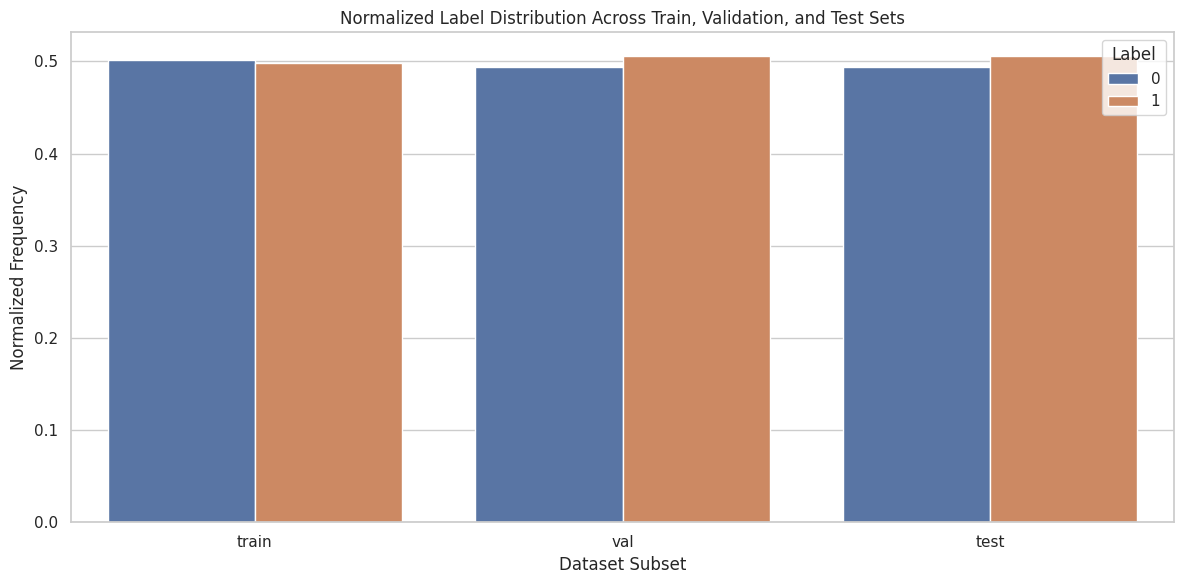

In [3]:
from src.data import VesselDataModule
from src.utils.data_analysis import data_info, check_class_distribution

data = VesselDataModule(config.dataset)
data_info(data)
check_class_distribution(data)

Plotting the data distribution projected in 2D using Principal Component Analysis.

Extracting Feature.FACE: 100%|██████████| 3999/3999 [00:03<00:00, 1093.16it/s]


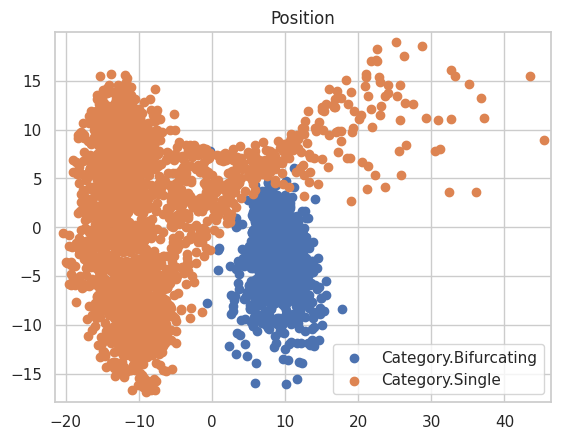

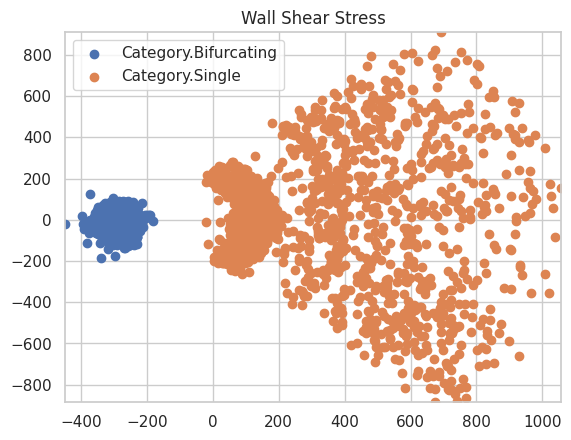

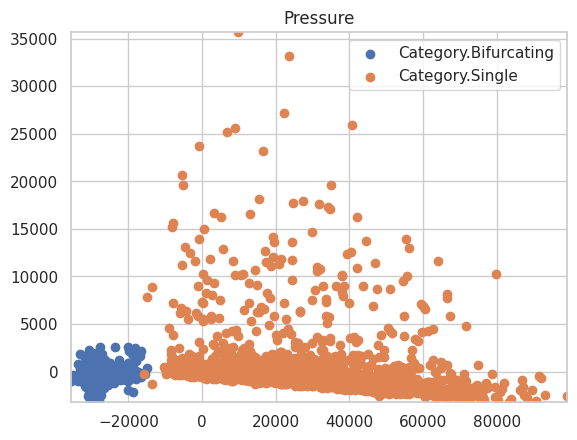

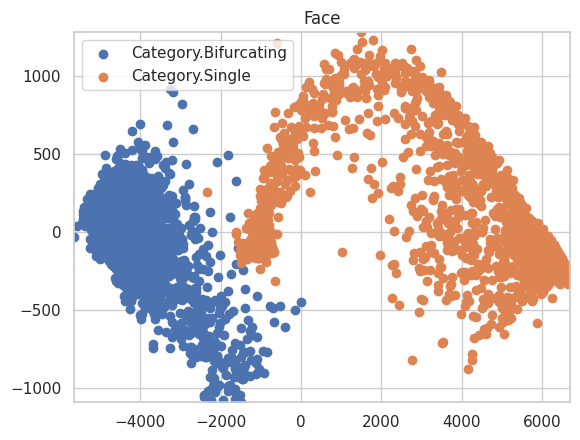

In [4]:
from src.utils.definitions import Feature, Category
from src.utils.data_analysis import plot_data

wss, labels = data.extract_feature(Feature.WSS)
pos, labels = data.extract_feature(Feature.POS)
pressure, labels = data.extract_feature(Feature.PRESSURE)
face, labels = data.extract_feature(Feature.FACE)
plot_data(pos, labels, Category, "Position")
plot_data(wss, labels, Category, "Wall Shear Stress")
plot_data(pressure, labels, Category, "Pressure")
plot_data(face, labels, Category, "Face")

---

### Equivariance Check
Performing equivariance check using random samples from the dataset.  
Geometric Layer is expected to fail due to lack of distance-aware dot product

In [5]:
from src.lib.geometricAlgebraElements import GeometricAlgebraBase
from src.test.test_equivariance import TestEquivariance
import unittest

dl = data.train_dataloader()
batch = next(iter(dl)).data[0]
batch = batch.view(-1, GeometricAlgebraBase.GA_size)[:10] # Flattening and taking only the first 10 elements
TestEquivariance.INPUT_DATA = batch # Setting the input data for the test

suite = unittest.TestSuite()
suite.addTests(unittest.TestLoader().loadTestsFromTestCase(TestEquivariance))
test_runner = unittest.TextTestRunner(verbosity=0)
restResult = test_runner.run(suite)


✅ GeometricBilinearLayer passed all equivariance tests               with a tolerance of 1e-05.              [10 inputs, 100 checks each]

✅ EquiLinearLayer passed all equivariance tests               with a tolerance of 1e-05.              [10 inputs, 100 checks each]

✅ EquiNormLayer passed all equivariance tests               with a tolerance of 1e-05.              [10 inputs, 100 checks each]


FAIL: test_geomattention_layer (src.test.test_equivariance.TestEquivariance)
Tests the equivariance of the GeometricAttentionLayer.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/src/test/test_equivariance.py", line 125, in test_geomattention_layer
    self.assertTrue(
AssertionError: False is not true : GeometricAttentionLayer failed the equivariance                     test for input 1

----------------------------------------------------------------------
Ran 5 tests in 5.996s

FAILED (failures=1)



✅ GatedGELU passed all equivariance tests               with a tolerance of 1e-05.              [10 inputs, 100 checks each]


---

### MLP Baseline

Running hyperparameter optimization to find the best hyperparameters maximizing the validation accuracy

In [6]:
from src.utils.hpo import mlp_hpo

mlp_hpo(config, data) # Hyperparameter optimization: writes the config file with the best hyperparameters

[I 2024-10-31 11:48:01,897] A new study created in memory with name: baseline_hpo


Starting a new hyperparameter optimization study...
Starting a new trial...
Trial number: 0
Learning rate: 0.001
Batch Size: 8


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | loss_fn        | BCEWithLogitsLoss  | 0      | train
1 | train_accuracy | BinaryAccuracy     | 0      | train
2 | val_accuracy   | BinaryAccuracy     | 0      | train
3 | test_accuracy  | BinaryAccuracy     | 0      | train
4 | train_f1       | BinaryF1Score      | 0      | train
5 | val_f1         | BinaryF1Score      | 0      | train
6 | test_f1        | BinaryF1Score      | 0      | train
7 | encoder        | TransformerEncoder | 2.2 K  | train
8 | embedder       | Linear             | 272    | train
9 | projection     | Linear             | 19.2 K | train
--------------------------------------------------------------
21.7 K    Trainable params
0         Non-trainable params
21.7 K    Total params
0.087  

Epoch 3: 100%|██████████| 375/375 [00:16<00:00, 22.22it/s, v_num=116, val/loss=0.047, val/acc=0.987, val/f1=0.987, train/loss=0.0274, train/acc=0.992, train/f1=0.992] 

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 375/375 [00:16<00:00, 22.21it/s, v_num=116, val/loss=0.047, val/acc=0.987, val/f1=0.987, train/loss=0.0274, train/acc=0.992, train/f1=0.992]


[I 2024-10-31 11:49:09,983] Trial 0 finished with value: 0.04697806388139725 and parameters: {'lr': 0.0001669972529293522, 'hidden_size': 16, 'batch_size': 8}. Best is trial 0 with value: 0.04697806388139725.


Trial 0 finished with value 0.04697806388139725
Starting a new trial...
Trial number: 1
Learning rate: 0.001
Batch Size: 4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | loss_fn        | BCEWithLogitsLoss  | 0      | train
1 | train_accuracy | BinaryAccuracy     | 0      | train
2 | val_accuracy   | BinaryAccuracy     | 0      | train
3 | test_accuracy  | BinaryAccuracy     | 0      | train
4 | train_f1       | BinaryF1Score      | 0      | train
5 | val_f1         | BinaryF1Score      | 0      | train
6 | test_f1        | BinaryF1Score      | 0      | train
7 | encoder        | TransformerEncoder | 2.2 K  | train
8 | embedder       | Linear             | 272    | train
9 | projection     | Linear             | 19.2 K | train
--------------------------------------------------------------
21.7 K    Trainable params
0         Non-trainable params
21.7 K    Total params
0.087  

Epoch 3: 100%|██████████| 750/750 [00:18<00:00, 40.54it/s, v_num=117, val/loss=0.000913, val/acc=1.000, val/f1=1.000, train/loss=0.00197, train/acc=0.999, train/f1=0.999]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 750/750 [00:18<00:00, 40.52it/s, v_num=117, val/loss=0.000913, val/acc=1.000, val/f1=1.000, train/loss=0.00197, train/acc=0.999, train/f1=0.999]


[I 2024-10-31 11:50:24,575] Trial 1 finished with value: 0.000912624120246619 and parameters: {'lr': 0.0001508952020053126, 'hidden_size': 16, 'batch_size': 4}. Best is trial 1 with value: 0.000912624120246619.


Trial 1 finished with value 0.000912624120246619
Starting a new trial...
Trial number: 2
Learning rate: 0.001
Batch Size: 16


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | loss_fn        | BCEWithLogitsLoss  | 0      | train
1 | train_accuracy | BinaryAccuracy     | 0      | train
2 | val_accuracy   | BinaryAccuracy     | 0      | train
3 | test_accuracy  | BinaryAccuracy     | 0      | train
4 | train_f1       | BinaryF1Score      | 0      | train
5 | val_f1         | BinaryF1Score      | 0      | train
6 | test_f1        | BinaryF1Score      | 0      | train
7 | encoder        | TransformerEncoder | 2.2 K  | train
8 | embedder       | Linear             | 272    | train
9 | projection     | Linear             | 19.2 K | train
--------------------------------------------------------------
21.7 K    Trainable params
0         Non-trainable params
21.7 K    Total params
0.087  

Epoch 3: 100%|██████████| 188/188 [00:17<00:00, 11.01it/s, v_num=118, val/loss=9.76e-5, val/acc=1.000, val/f1=1.000, train/loss=3.09e-5, train/acc=1.000, train/f1=1.000]  

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 188/188 [00:17<00:00, 11.00it/s, v_num=118, val/loss=9.76e-5, val/acc=1.000, val/f1=1.000, train/loss=3.09e-5, train/acc=1.000, train/f1=1.000]


[I 2024-10-31 11:51:33,685] Trial 2 finished with value: 9.756696090335026e-05 and parameters: {'lr': 0.0009110583404755149, 'hidden_size': 16, 'batch_size': 16}. Best is trial 2 with value: 9.756696090335026e-05.


Trial 2 finished with value 9.756696090335026e-05
Starting a new trial...
Trial number: 3
Learning rate: 0.001
Batch Size: 4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | loss_fn        | BCEWithLogitsLoss  | 0      | train
1 | train_accuracy | BinaryAccuracy     | 0      | train
2 | val_accuracy   | BinaryAccuracy     | 0      | train
3 | test_accuracy  | BinaryAccuracy     | 0      | train
4 | train_f1       | BinaryF1Score      | 0      | train
5 | val_f1         | BinaryF1Score      | 0      | train
6 | test_f1        | BinaryF1Score      | 0      | train
7 | encoder        | TransformerEncoder | 2.2 K  | train
8 | embedder       | Linear             | 272    | train
9 | projection     | Linear             | 19.2 K | train
--------------------------------------------------------------
21.7 K    Trainable params
0         Non-trainable params
21.7 K    Total params
0.087  

Epoch 3: 100%|██████████| 750/750 [00:19<00:00, 38.21it/s, v_num=119, val/loss=0.00016, val/acc=1.000, val/f1=1.000, train/loss=6.3e-5, train/acc=1.000, train/f1=1.000]   

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 750/750 [00:19<00:00, 38.18it/s, v_num=119, val/loss=0.00016, val/acc=1.000, val/f1=1.000, train/loss=6.3e-5, train/acc=1.000, train/f1=1.000]


[I 2024-10-31 11:52:51,729] Trial 3 finished with value: 0.00015973228437360376 and parameters: {'lr': 0.0003898205785419069, 'hidden_size': 32, 'batch_size': 4}. Best is trial 2 with value: 9.756696090335026e-05.


Trial 3 finished with value 0.00015973228437360376
Hyperparameter optimization completed.
Best hyperparameters found:
          Learning rate: 0.0009110583404755149
          Batch Size: 16



Training the model using the best hyperparameters

In [7]:
from src.trainer import VesselTrainer
from src.models import BaselineMLP

model = BaselineMLP(config.mlp)
trainer = VesselTrainer(config.trainer, "mlp")
trainer.fit(model, data)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: neverorfrog (neverorfrog-sapienza). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/daniaffch/.netrc


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | loss_fn        | BCEWithLogitsLoss | 0      | train
1 | train_accuracy | BinaryAccuracy    | 0      | train
2 | val_accuracy   | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | train_f1       | BinaryF1Score     | 0      | train
5 | val_f1         | BinaryF1Score     | 0      | train
6 | test_f1        | BinaryF1Score     | 0      | train
7 | fc             | Sequential        | 614 K  | train
-------------------------------------------------------------
614 K     Trainable params
0         Non-trainable params
614 K     Total params
2.460     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 188/188 [00:07<00:00, 25.96it/s, v_num=gqkh, val/loss=0.057, val/acc=0.983, val/f1=0.984, train/loss=0.135, train/acc=0.963, train/f1=0.962]

Metric val/loss improved. New best score: 0.057
Epoch 0, global step 188: 'val/loss' reached 0.05696 (best 0.05696), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=0-step=188.ckpt' as top 1


Epoch 1: 100%|██████████| 188/188 [00:08<00:00, 22.47it/s, v_num=gqkh, val/loss=0.0226, val/acc=0.988, val/f1=0.989, train/loss=0.029, train/acc=0.992, train/f1=0.992]

Metric val/loss improved by 0.034 >= min_delta = 1e-05. New best score: 0.023
Epoch 1, global step 376: 'val/loss' reached 0.02259 (best 0.02259), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=1-step=376.ckpt' as top 1


Epoch 2: 100%|██████████| 188/188 [00:08<00:00, 22.63it/s, v_num=gqkh, val/loss=0.0154, val/acc=0.995, val/f1=0.995, train/loss=0.0161, train/acc=0.995, train/f1=0.995]

Metric val/loss improved by 0.007 >= min_delta = 1e-05. New best score: 0.015
Epoch 2, global step 564: 'val/loss' reached 0.01540 (best 0.01540), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=2-step=564.ckpt' as top 1


Epoch 3: 100%|██████████| 188/188 [00:08<00:00, 21.78it/s, v_num=gqkh, val/loss=0.00825, val/acc=0.997, val/f1=0.997, train/loss=0.0128, train/acc=0.995, train/f1=0.995]

Metric val/loss improved by 0.007 >= min_delta = 1e-05. New best score: 0.008
Epoch 3, global step 752: 'val/loss' reached 0.00825 (best 0.00825), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=3-step=752-v1.ckpt' as top 1


Epoch 4: 100%|██████████| 188/188 [00:08<00:00, 22.12it/s, v_num=gqkh, val/loss=0.0145, val/acc=0.990, val/f1=0.990, train/loss=0.0116, train/acc=0.997, train/f1=0.997] 

Epoch 4, global step 940: 'val/loss' was not in top 1


Epoch 5: 100%|██████████| 188/188 [00:08<00:00, 22.07it/s, v_num=gqkh, val/loss=0.00497, val/acc=0.997, val/f1=0.997, train/loss=0.00949, train/acc=0.997, train/f1=0.997]

Metric val/loss improved by 0.003 >= min_delta = 1e-05. New best score: 0.005
Epoch 5, global step 1128: 'val/loss' reached 0.00497 (best 0.00497), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=5-step=1128.ckpt' as top 1


Epoch 6: 100%|██████████| 188/188 [00:08<00:00, 22.84it/s, v_num=gqkh, val/loss=0.025, val/acc=0.990, val/f1=0.990, train/loss=0.00542, train/acc=0.998, train/f1=0.998]  

Epoch 6, global step 1316: 'val/loss' was not in top 1


Epoch 7: 100%|██████████| 188/188 [00:08<00:00, 22.44it/s, v_num=gqkh, val/loss=0.00268, val/acc=0.998, val/f1=0.998, train/loss=0.00352, train/acc=0.999, train/f1=0.999]

Metric val/loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.003
Epoch 7, global step 1504: 'val/loss' reached 0.00268 (best 0.00268), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=7-step=1504-v1.ckpt' as top 1


Epoch 8: 100%|██████████| 188/188 [00:08<00:00, 22.75it/s, v_num=gqkh, val/loss=0.00656, val/acc=0.997, val/f1=0.997, train/loss=0.00198, train/acc=0.999, train/f1=0.999]

Epoch 8, global step 1692: 'val/loss' was not in top 1


Epoch 9: 100%|██████████| 188/188 [00:08<00:00, 23.41it/s, v_num=gqkh, val/loss=0.00402, val/acc=0.998, val/f1=0.998, train/loss=0.00182, train/acc=0.999, train/f1=0.999]

Epoch 9, global step 1880: 'val/loss' was not in top 1


Epoch 10: 100%|██████████| 188/188 [00:08<00:00, 23.26it/s, v_num=gqkh, val/loss=0.00505, val/acc=0.997, val/f1=0.997, train/loss=0.00111, train/acc=1.000, train/f1=1.000]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.003. Signaling Trainer to stop.
Epoch 10, global step 2068: 'val/loss' was not in top 1


Epoch 10: 100%|██████████| 188/188 [00:08<00:00, 23.25it/s, v_num=gqkh, val/loss=0.00505, val/acc=0.997, val/f1=0.997, train/loss=0.00111, train/acc=1.000, train/f1=1.000]


Test the model performance on unseen test data.

Restoring states from the checkpoint path at /home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=7-step=1504-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=7-step=1504-v1.ckpt


Testing DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 114.66it/s]

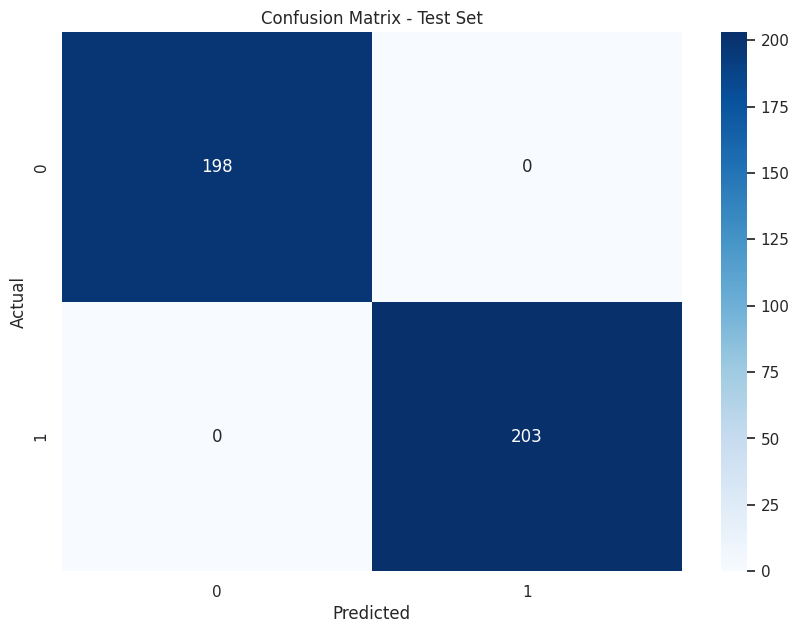

Testing DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 59.38it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │            1.0            │
│          test/f1          │            1.0            │
│         test/loss         │   0.0024689773563295603   │
└───────────────────────────┴───────────────────────────┘

In [8]:
trainer.test(model, data)

### Attention based Baseline

Running hyperparameter optimization to find the best hyperparameters maximizing the validation accuracy

In [9]:
from src.utils.hpo import baseline_hpo

baseline_hpo(config, data) # Hyperparameter optimization: writes the config file with the best hyperparameters

[I 2024-10-31 11:54:29,875] A new study created in memory with name: baseline_hpo
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | loss_fn        | BCEWithLogitsLoss  | 0      | train
1 | train_accuracy | BinaryAccuracy     | 0      | train
2 | val_accuracy   | BinaryAccuracy     | 0      | train
3 | test_accuracy  | BinaryAccuracy     | 0      | train
4 | train_f1       | BinaryF1Score      | 0      | train
5 | val_f1         | BinaryF1Score      | 0      | train
6 | test_f1        | BinaryF1Score      | 0      | train
7 | encoder        | TransformerEncoder | 2.2 K  | train
8 | embedder       | Linear             | 272    | train
9 | projection     | Linear             | 19.2 K | train
--------------------------------------------------------------
21.7 K

Starting a new hyperparameter optimization study...
Starting a new trial...
Trial number: 0
Learning rate: 0.0001669972529293522
Attention Heads: 2
Attention Layers: 1
Batch Size: 4
Epoch 3: 100%|██████████| 750/750 [00:18<00:00, 39.49it/s, v_num=120, val/loss=0.0495, val/acc=0.988, val/f1=0.989, train/loss=0.0681, train/acc=0.976, train/f1=0.976]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 750/750 [00:19<00:00, 39.47it/s, v_num=120, val/loss=0.0495, val/acc=0.988, val/f1=0.989, train/loss=0.0681, train/acc=0.976, train/f1=0.976]


[I 2024-10-31 11:55:46,761] Trial 0 finished with value: 0.04949214309453964 and parameters: {'lr': 0.0001669972529293522, 'num_heads': 2, 'num_layers': 1, 'batch_size': 4}. Best is trial 0 with value: 0.04949214309453964.


Trial 0 finished with value 0.04949214309453964
Starting a new trial...
Trial number: 1
Learning rate: 0.00029059244064864577


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Attention Heads: 4
Attention Layers: 3
Batch Size: 4


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | loss_fn        | BCEWithLogitsLoss  | 0      | train
1 | train_accuracy | BinaryAccuracy     | 0      | train
2 | val_accuracy   | BinaryAccuracy     | 0      | train
3 | test_accuracy  | BinaryAccuracy     | 0      | train
4 | train_f1       | BinaryF1Score      | 0      | train
5 | val_f1         | BinaryF1Score      | 0      | train
6 | test_f1        | BinaryF1Score      | 0      | train
7 | encoder        | TransformerEncoder | 2.2 K  | train
8 | embedder       | Linear             | 272    | train
9 | projection     | Linear             | 19.2 K | train
--------------------------------------------------------------
21.7 K    Trainable params
0         Non-trainable params
21.7 K    Total params
0.087     Total estimated model params size (MB)


Epoch 3: 100%|██████████| 750/750 [00:19<00:00, 37.75it/s, v_num=121, val/loss=0.012, val/acc=0.995, val/f1=0.995, train/loss=0.0206, train/acc=0.994, train/f1=0.994] 

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 750/750 [00:19<00:00, 37.73it/s, v_num=121, val/loss=0.012, val/acc=0.995, val/f1=0.995, train/loss=0.0206, train/acc=0.994, train/f1=0.994]


[I 2024-10-31 11:57:06,095] Trial 1 finished with value: 0.011972451582551003 and parameters: {'lr': 0.00029059244064864577, 'num_heads': 4, 'num_layers': 3, 'batch_size': 4}. Best is trial 1 with value: 0.011972451582551003.


Trial 1 finished with value 0.011972451582551003
Starting a new trial...
Trial number: 2
Learning rate: 0.000850280548262009
Attention Heads: 2
Attention Layers: 2
Batch Size: 4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | loss_fn        | BCEWithLogitsLoss  | 0      | train
1 | train_accuracy | BinaryAccuracy     | 0      | train
2 | val_accuracy   | BinaryAccuracy     | 0      | train
3 | test_accuracy  | BinaryAccuracy     | 0      | train
4 | train_f1       | BinaryF1Score      | 0      | train
5 | val_f1         | BinaryF1Score      | 0      | train
6 | test_f1        | BinaryF1Score      | 0      | train
7 | encoder        | TransformerEncoder | 2.2 K  | train
8 | embedder       | Linear             | 272    | train
9 | projection     | Linear             | 19.2 K | train
--------------------------------------------------------------
21.7 K    Trainable params
0         Non-trainable params
21.7 K    Total params
0.087  

Epoch 3: 100%|██████████| 750/750 [00:19<00:00, 38.09it/s, v_num=122, val/loss=0.000933, val/acc=1.000, val/f1=1.000, train/loss=0.00337, train/acc=0.999, train/f1=0.999]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 750/750 [00:19<00:00, 38.06it/s, v_num=122, val/loss=0.000933, val/acc=1.000, val/f1=1.000, train/loss=0.00337, train/acc=0.999, train/f1=0.999]


[I 2024-10-31 11:58:25,983] Trial 2 finished with value: 0.0009332553017884493 and parameters: {'lr': 0.000850280548262009, 'num_heads': 2, 'num_layers': 2, 'batch_size': 4}. Best is trial 2 with value: 0.0009332553017884493.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | loss_fn        | BCEWithLogitsLoss  | 0      | train
1 | train_accuracy | BinaryAccuracy     | 0      | train
2 | val_accuracy   | BinaryAccuracy     | 0      | train
3 | test_accuracy  | BinaryAccuracy     | 0      | train
4 | train_f1       | BinaryF1Score      | 0      | train
5 | val_f1         | BinaryF1Score      | 0      | train
6 | test_f1        | BinaryF1Score      | 0      | train
7 | encoder        | TransformerEncoder | 2.2 K  | train
8 | embedder       | Linear            

Trial 2 finished with value 0.0009332553017884493
Starting a new trial...
Trial number: 3
Learning rate: 0.00026796271555330157
Attention Heads: 4
Attention Layers: 2
Batch Size: 4
Epoch 3: 100%|██████████| 750/750 [00:19<00:00, 38.34it/s, v_num=123, val/loss=0.000568, val/acc=1.000, val/f1=1.000, train/loss=0.00019, train/acc=1.000, train/f1=1.000] 

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 750/750 [00:19<00:00, 38.32it/s, v_num=123, val/loss=0.000568, val/acc=1.000, val/f1=1.000, train/loss=0.00019, train/acc=1.000, train/f1=1.000]


[I 2024-10-31 11:59:44,937] Trial 3 finished with value: 0.0005683890194632113 and parameters: {'lr': 0.00026796271555330157, 'num_heads': 4, 'num_layers': 2, 'batch_size': 4}. Best is trial 3 with value: 0.0005683890194632113.


Trial 3 finished with value 0.0005683890194632113
Hyperparameter optimization completed.
Best hyperparameters found:
          Learning rate: 0.00026796271555330157
          Number of Attention Heads: 4
          Number of Attention Layers: 2
          Batch Size: 4



Training the model using the best hyperparameters

In [10]:
from src.trainer import VesselTrainer
from src.models import BaselineTransformer

model = BaselineTransformer(config.baseline)
trainer = VesselTrainer(config.trainer, "transformer")
trainer.fit(model, data)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇█
test/acc,▁
test/f1,▁
test/loss,▁
train/acc,▁▆▇▇▇▇█████
train/f1,▁▆▇▇▇▇█████
train/loss,█▂▂▂▂▁▁▁▁▁▁
trainer/global_step,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▆▆▇▇▇▇███
val/acc,▁▃▆▇▄▇▄█▇█▇
val/f1,▁▃▆▇▄▇▄█▇█▇
val/loss,█▄▃▂▃▁▄▁▂▁▁


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | loss_fn        | BCEWithLogitsLoss  | 0      | train
1 | train_accuracy | BinaryAccuracy     | 0      | train
2 | val_accuracy   | BinaryAccuracy     | 0      | train
3 | test_accuracy  | BinaryAccuracy     | 0      | train
4 | train_f1       | BinaryF1Score      | 0      | train
5 | val_f1         | BinaryF1Score      | 0      | train
6 | test_f1        | BinaryF1Score      | 0      | train
7 | encoder        | TransformerEncoder | 4.5 K  | train
8 | embedder       | Linear             | 272    | train
9 | projection     | Linear             | 19.2 K | train
--------------------------------------------------------------
24.0 K    Trainable params
0         Non-trainable params
24.0 K    Total params
0.096  

Epoch 0: 100%|██████████| 750/750 [00:32<00:00, 23.27it/s, v_num=e8df, val/loss=0.065, val/acc=0.983, val/f1=0.984, train/loss=0.298, train/acc=0.849, train/f1=0.851]

Metric val/loss improved. New best score: 0.065
Epoch 0, global step 750: 'val/loss' reached 0.06499 (best 0.06499), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=0-step=750-v1.ckpt' as top 1


Epoch 1: 100%|██████████| 750/750 [00:32<00:00, 22.80it/s, v_num=e8df, val/loss=0.0558, val/acc=0.987, val/f1=0.987, train/loss=0.0859, train/acc=0.967, train/f1=0.967]

Metric val/loss improved by 0.009 >= min_delta = 1e-05. New best score: 0.056
Epoch 1, global step 1500: 'val/loss' reached 0.05579 (best 0.05579), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=1-step=1500.ckpt' as top 1


Epoch 2: 100%|██████████| 750/750 [00:33<00:00, 22.36it/s, v_num=e8df, val/loss=0.0508, val/acc=0.987, val/f1=0.987, train/loss=0.075, train/acc=0.974, train/f1=0.974] 

Metric val/loss improved by 0.005 >= min_delta = 1e-05. New best score: 0.051
Epoch 2, global step 2250: 'val/loss' reached 0.05082 (best 0.05082), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=2-step=2250.ckpt' as top 1


Epoch 3: 100%|██████████| 750/750 [00:33<00:00, 22.22it/s, v_num=e8df, val/loss=0.102, val/acc=0.973, val/f1=0.974, train/loss=0.056, train/acc=0.981, train/f1=0.981] 

Epoch 3, global step 3000: 'val/loss' was not in top 1


Epoch 4: 100%|██████████| 750/750 [00:33<00:00, 22.23it/s, v_num=e8df, val/loss=0.0585, val/acc=0.988, val/f1=0.989, train/loss=0.0526, train/acc=0.983, train/f1=0.983]

Epoch 4, global step 3750: 'val/loss' was not in top 1


Epoch 5: 100%|██████████| 750/750 [00:33<00:00, 22.48it/s, v_num=e8df, val/loss=0.103, val/acc=0.967, val/f1=0.968, train/loss=0.0413, train/acc=0.987, train/f1=0.987] 

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.051. Signaling Trainer to stop.
Epoch 5, global step 4500: 'val/loss' was not in top 1


Epoch 5: 100%|██████████| 750/750 [00:33<00:00, 22.47it/s, v_num=e8df, val/loss=0.103, val/acc=0.967, val/f1=0.968, train/loss=0.0413, train/acc=0.987, train/f1=0.987]


Test the model performance on unseen test data.

Restoring states from the checkpoint path at /home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=2-step=2250.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=2-step=2250.ckpt


Testing DataLoader 0: 100%|██████████| 101/101 [00:02<00:00, 48.40it/s]

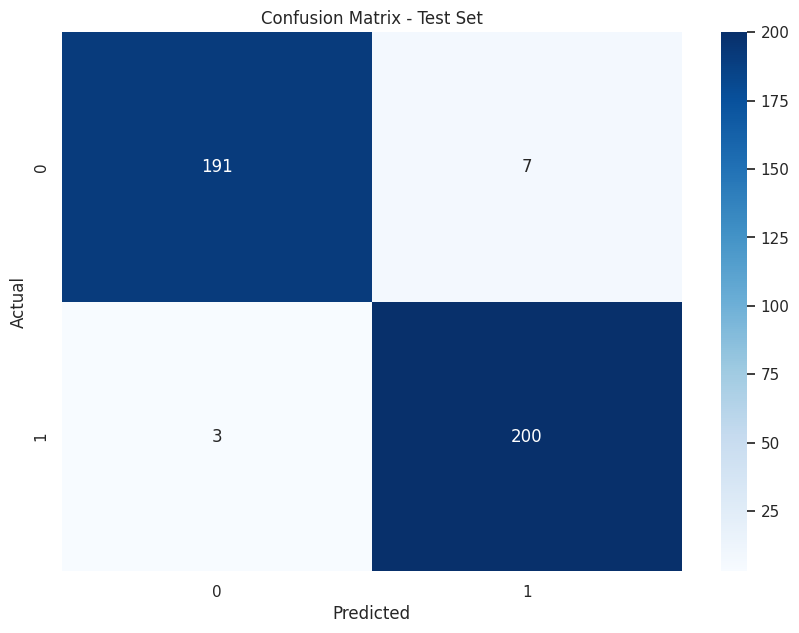

Testing DataLoader 0: 100%|██████████| 101/101 [00:02<00:00, 44.13it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │     0.975062370300293     │
│          test/f1          │    0.9756097793579102     │
│         test/loss         │    0.05774170905351639    │
└───────────────────────────┴───────────────────────────┘

In [11]:
trainer.test(model, data)

---

### GATr

Running hyperparameter optimization to find the best hyperparameters maximizing the validation accuracy

In [12]:
from src.models import Gatr
from src.utils.hpo import gatr_hpo

gatr_hpo(config, data) # Hyperparameter optimization: writes the config file with the best hyperparameters

[I 2024-10-31 12:03:16,320] A new study created in memory with name: gatr_hpo
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params | Mode 
--------------------------------------------------------------
0 | loss_fn         | BCEWithLogitsLoss | 0      | train
1 | train_accuracy  | BinaryAccuracy    | 0      | train
2 | val_accuracy    | BinaryAccuracy    | 0      | train
3 | test_accuracy   | BinaryAccuracy    | 0      | train
4 | train_f1        | BinaryF1Score     | 0      | train
5 | val_f1          | BinaryF1Score     | 0      | train
6 | test_f1         | BinaryF1Score     | 0      | train
7 | hsProjection    | EquiLinearLayer   | 576    | train
8 | backbone        | ModuleList        | 25.3 K | train
9 | finalProjection | Linear            | 76.8 K | train
--------------------------------------------------------------
102 K     

Starting a new hyperparameter optimization study...
Starting a new trial...
Trial number: 0
Learning rate: 0.0001669972529293522
Attention Heads: 2
Attention Layers: 1
Batch Size: 4
Epoch 3: 100%|██████████| 750/750 [00:15<00:00, 47.27it/s, v_num=124, val/loss=0.0191, val/acc=0.990, val/f1=0.990, train/loss=0.018, train/acc=0.995, train/f1=0.995] 

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 750/750 [00:15<00:00, 47.24it/s, v_num=124, val/loss=0.0191, val/acc=0.990, val/f1=0.990, train/loss=0.018, train/acc=0.995, train/f1=0.995]


[I 2024-10-31 12:04:20,162] Trial 0 finished with value: 0.019137676805257797 and parameters: {'lr': 0.0001669972529293522, 'num_heads': 2, 'num_layers': 1, 'batch_size': 4}. Best is trial 0 with value: 0.019137676805257797.


Trial 0 finished with value 0.019137676805257797
Starting a new trial...
Trial number: 1
Learning rate: 0.00029059244064864577
Attention Heads: 4
Attention Layers: 3
Batch Size: 4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params | Mode 
--------------------------------------------------------------
0 | loss_fn         | BCEWithLogitsLoss | 0      | train
1 | train_accuracy  | BinaryAccuracy    | 0      | train
2 | val_accuracy    | BinaryAccuracy    | 0      | train
3 | test_accuracy   | BinaryAccuracy    | 0      | train
4 | train_f1        | BinaryF1Score     | 0      | train
5 | val_f1          | BinaryF1Score     | 0      | train
6 | test_f1         | BinaryF1Score     | 0      | train
7 | hsProjection    | EquiLinearLayer   | 576    | train
8 | backbone        | ModuleList        | 25.3 K | train
9 | finalProjection | Linear            | 76.8 K | train
--------------------------------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.411  

Epoch 3: 100%|██████████| 750/750 [00:18<00:00, 40.53it/s, v_num=125, val/loss=0.0539, val/acc=0.985, val/f1=0.985, train/loss=0.000285, train/acc=1.000, train/f1=1.000]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 750/750 [00:18<00:00, 40.51it/s, v_num=125, val/loss=0.0539, val/acc=0.985, val/f1=0.985, train/loss=0.000285, train/acc=1.000, train/f1=1.000]


[I 2024-10-31 12:05:30,195] Trial 1 finished with value: 0.053928762674331665 and parameters: {'lr': 0.00029059244064864577, 'num_heads': 4, 'num_layers': 3, 'batch_size': 4}. Best is trial 0 with value: 0.019137676805257797.


Trial 1 finished with value 0.053928762674331665
Starting a new trial...
Trial number: 2
Learning rate: 0.000850280548262009
Attention Heads: 2
Attention Layers: 2
Batch Size: 4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params | Mode 
--------------------------------------------------------------
0 | loss_fn         | BCEWithLogitsLoss | 0      | train
1 | train_accuracy  | BinaryAccuracy    | 0      | train
2 | val_accuracy    | BinaryAccuracy    | 0      | train
3 | test_accuracy   | BinaryAccuracy    | 0      | train
4 | train_f1        | BinaryF1Score     | 0      | train
5 | val_f1          | BinaryF1Score     | 0      | train
6 | test_f1         | BinaryF1Score     | 0      | train
7 | hsProjection    | EquiLinearLayer   | 576    | train
8 | backbone        | ModuleList        | 25.3 K | train
9 | finalProjection | Linear            | 76.8 K | train
--------------------------------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.411  

Epoch 3: 100%|██████████| 750/750 [00:17<00:00, 42.14it/s, v_num=126, val/loss=0.000748, val/acc=1.000, val/f1=1.000, train/loss=0.001, train/acc=1.000, train/f1=1.000] 

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 750/750 [00:17<00:00, 42.10it/s, v_num=126, val/loss=0.000748, val/acc=1.000, val/f1=1.000, train/loss=0.001, train/acc=1.000, train/f1=1.000]


[I 2024-10-31 12:06:42,489] Trial 2 finished with value: 0.000747724378015846 and parameters: {'lr': 0.000850280548262009, 'num_heads': 2, 'num_layers': 2, 'batch_size': 4}. Best is trial 2 with value: 0.000747724378015846.
GPU available: True (cuda), used: True


Trial 2 finished with value 0.000747724378015846
Starting a new trial...
Trial number: 3
Learning rate: 0.00026796271555330157
Attention Heads: 4
Attention Layers: 2
Batch Size: 4


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params | Mode 
--------------------------------------------------------------
0 | loss_fn         | BCEWithLogitsLoss | 0      | train
1 | train_accuracy  | BinaryAccuracy    | 0      | train
2 | val_accuracy    | BinaryAccuracy    | 0      | train
3 | test_accuracy   | BinaryAccuracy    | 0      | train
4 | train_f1        | BinaryF1Score     | 0      | train
5 | val_f1          | BinaryF1Score     | 0      | train
6 | test_f1         | BinaryF1Score     | 0      | train
7 | hsProjection    | EquiLinearLayer   | 576    | train
8 | backbone        | ModuleList        | 25.3 K | train
9 | finalProjection | Linear            | 76.8 K | train
--------------------------------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.411     Total estimated model params size (M

Epoch 3: 100%|██████████| 750/750 [00:17<00:00, 43.24it/s, v_num=127, val/loss=3.92e-6, val/acc=1.000, val/f1=1.000, train/loss=1.11e-5, train/acc=1.000, train/f1=1.000]  

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 750/750 [00:17<00:00, 43.21it/s, v_num=127, val/loss=3.92e-6, val/acc=1.000, val/f1=1.000, train/loss=1.11e-5, train/acc=1.000, train/f1=1.000]


[I 2024-10-31 12:07:52,799] Trial 3 finished with value: 3.9174356061266735e-06 and parameters: {'lr': 0.00026796271555330157, 'num_heads': 4, 'num_layers': 2, 'batch_size': 4}. Best is trial 3 with value: 3.9174356061266735e-06.


Trial 3 finished with value 3.9174356061266735e-06
Hyperparameter optimization completed.
Best hyperparameters found:
          Learning rate: 0.00026796271555330157
          Number of Attention Heads: 4
          Number of Attention Layers: 2
          Batch Size: 4



Training the model using the best hyperparameters

In [13]:
from src.trainer import VesselTrainer

model = Gatr(config.gatr)
trainer = VesselTrainer(config.trainer, "gatr")
trainer.fit(model, data)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▁▁▂▂▃▃▅▅▆▆▇▇█
test/acc,▁
test/f1,▁
test/loss,▁
train/acc,▁▇▇███
train/f1,▁▇▇███
train/loss,█▂▂▁▁▁
trainer/global_step,▁▁▂▂▄▄▅▅▇▇███
val/acc,▆▇▇▃█▁
val/f1,▆▇▇▃█▁
val/loss,▃▂▁█▂█


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params | Mode 
--------------------------------------------------------------
0 | loss_fn         | BCEWithLogitsLoss | 0      | train
1 | train_accuracy  | BinaryAccuracy    | 0      | train
2 | val_accuracy    | BinaryAccuracy    | 0      | train
3 | test_accuracy   | BinaryAccuracy    | 0      | train
4 | train_f1        | BinaryF1Score     | 0      | train
5 | val_f1          | BinaryF1Score     | 0      | train
6 | test_f1         | BinaryF1Score     | 0      | train
7 | hsProjection    | EquiLinearLayer   | 576    | train
8 | backbone        | ModuleList        | 50.7 K | train
9 | finalProjection | Linear            | 76.8 K | train
--------------------------------------------------------------
128 K     Trainable params
0         Non-trainable params
128 K     Total params
0.512  

Epoch 0: 100%|██████████| 750/750 [00:20<00:00, 35.77it/s, v_num=055t, val/loss=0.0442, val/acc=0.988, val/f1=0.989, train/loss=0.0984, train/acc=0.966, train/f1=0.966]

Metric val/loss improved. New best score: 0.044
Epoch 0, global step 750: 'val/loss' reached 0.04421 (best 0.04421), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=0-step=750-v1.ckpt' as top 1


Epoch 1: 100%|██████████| 750/750 [00:21<00:00, 34.28it/s, v_num=055t, val/loss=0.0345, val/acc=0.990, val/f1=0.990, train/loss=0.0354, train/acc=0.991, train/f1=0.991]

Metric val/loss improved by 0.010 >= min_delta = 1e-05. New best score: 0.035
Epoch 1, global step 1500: 'val/loss' reached 0.03450 (best 0.03450), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=1-step=1500.ckpt' as top 1


Epoch 2: 100%|██████████| 750/750 [00:21<00:00, 34.32it/s, v_num=055t, val/loss=0.0233, val/acc=0.990, val/f1=0.990, train/loss=0.0232, train/acc=0.992, train/f1=0.992]

Metric val/loss improved by 0.011 >= min_delta = 1e-05. New best score: 0.023
Epoch 2, global step 2250: 'val/loss' reached 0.02332 (best 0.02332), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=2-step=2250-v1.ckpt' as top 1


Epoch 3: 100%|██████████| 750/750 [00:22<00:00, 34.04it/s, v_num=055t, val/loss=0.00831, val/acc=0.995, val/f1=0.995, train/loss=0.0116, train/acc=0.997, train/f1=0.997]

Metric val/loss improved by 0.015 >= min_delta = 1e-05. New best score: 0.008
Epoch 3, global step 3000: 'val/loss' reached 0.00831 (best 0.00831), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=3-step=3000.ckpt' as top 1


Epoch 4: 100%|██████████| 750/750 [00:24<00:00, 31.00it/s, v_num=055t, val/loss=0.00419, val/acc=1.000, val/f1=1.000, train/loss=0.00846, train/acc=0.997, train/f1=0.997]

Metric val/loss improved by 0.004 >= min_delta = 1e-05. New best score: 0.004
Epoch 4, global step 3750: 'val/loss' reached 0.00419 (best 0.00419), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=4-step=3750.ckpt' as top 1


Epoch 5: 100%|██████████| 750/750 [00:23<00:00, 31.95it/s, v_num=055t, val/loss=0.00274, val/acc=1.000, val/f1=1.000, train/loss=0.00405, train/acc=0.998, train/f1=0.998]

Metric val/loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.003
Epoch 5, global step 4500: 'val/loss' reached 0.00274 (best 0.00274), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=5-step=4500.ckpt' as top 1


Epoch 6: 100%|██████████| 750/750 [00:26<00:00, 28.75it/s, v_num=055t, val/loss=4.79e-5, val/acc=1.000, val/f1=1.000, train/loss=0.000589, train/acc=1.000, train/f1=1.000]

Metric val/loss improved by 0.003 >= min_delta = 1e-05. New best score: 0.000
Epoch 6, global step 5250: 'val/loss' reached 0.00005 (best 0.00005), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=6-step=5250.ckpt' as top 1


Epoch 7: 100%|██████████| 750/750 [00:27<00:00, 27.69it/s, v_num=055t, val/loss=2.91e-5, val/acc=1.000, val/f1=1.000, train/loss=0.00046, train/acc=1.000, train/f1=1.000] 

Metric val/loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.000
Epoch 7, global step 6000: 'val/loss' reached 0.00003 (best 0.00003), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=7-step=6000-v1.ckpt' as top 1


Epoch 8: 100%|██████████| 750/750 [00:25<00:00, 29.71it/s, v_num=055t, val/loss=3.32e-5, val/acc=1.000, val/f1=1.000, train/loss=1.67e-5, train/acc=1.000, train/f1=1.000]

Epoch 8, global step 6750: 'val/loss' was not in top 1


Epoch 9: 100%|██████████| 750/750 [00:24<00:00, 30.91it/s, v_num=055t, val/loss=3.47e-5, val/acc=1.000, val/f1=1.000, train/loss=1.74e-5, train/acc=1.000, train/f1=1.000]

Epoch 9, global step 7500: 'val/loss' was not in top 1


Epoch 10: 100%|██████████| 750/750 [00:23<00:00, 31.35it/s, v_num=055t, val/loss=0.000381, val/acc=1.000, val/f1=1.000, train/loss=0.0124, train/acc=0.996, train/f1=0.996] 

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.000. Signaling Trainer to stop.
Epoch 10, global step 8250: 'val/loss' was not in top 1


Epoch 10: 100%|██████████| 750/750 [00:23<00:00, 31.34it/s, v_num=055t, val/loss=0.000381, val/acc=1.000, val/f1=1.000, train/loss=0.0124, train/acc=0.996, train/f1=0.996]


Test the model performance on unseen test data.

Restoring states from the checkpoint path at /home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=7-step=6000-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=7-step=6000-v1.ckpt


Testing DataLoader 0: 100%|██████████| 101/101 [00:01<00:00, 74.35it/s]

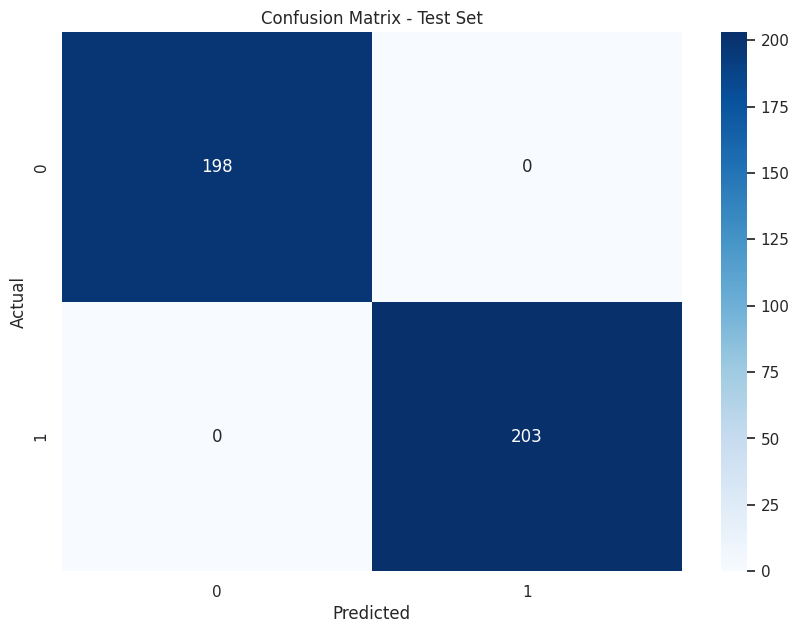

Testing DataLoader 0: 100%|██████████| 101/101 [00:01<00:00, 63.00it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │            1.0            │
│          test/f1          │            1.0            │
│         test/loss         │   1.003686793410452e-05   │
└───────────────────────────┴───────────────────────────┘

In [14]:
trainer.test(model, data)

----